In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

from functools import partial

import numpy as np
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.pca as pca
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth
import mlgrad.inventory as inventory
from mlgrad.af import averaging_function
import mlgrad.avragg as avragg

import rampy
import pybaselines
import random

from irsa import io
from irsa.preprocess import despike, utils
import irsa.widgets as widgets
import irsa.spectra as spectra
import irsa.io as io

import scipy.special as special

import copy

import ipywidgets
from IPython.display import display

import sys
print(sys.version)

# %matplotlib widget

3.13.2 (main, Feb  5 2025, 01:23:35) [GCC 14.2.0]


In [16]:
# path = f"/home/intellimath/repos/spectra/bacteria1024"
# path = f"/home/intellimath/repos/spectra/bacteria250310"
path = f"/home/intellimath/repos/spectra/mechanical_lysis"
# path = f"/home/intellimath/repos/spectra/thermal_lysis"
options = {}
dd = {}
widgets.load_spectras(path, dd, options)

Box(children=(VBox(children=(Label(value='дата:', style=LabelStyle(font_size='8pt', font_weight='bold')), Sele…

Button(description='Select', style=ButtonStyle())

Output()

{}

In [17]:
# dd = io.load_spectras(path, {"вид_бактерий":"STR", "отсечки_по_молекулярной_массе":"less30more10"})
# dd = io.load_spectras(path, {"штамм_бактерий":["36", "95"]})
# dd = io.load_spectras(path, {})
print(list(dd.keys()))

d_keys = list(sorted(dd.keys()))
sel_i = 0
sel = ipywidgets.Dropdown(options=d_keys,  description="Experiment:", rows=len(dd)+1)
sel.layout.width="50%"

['20241219_SA_95_R_less100_6_1_5_mechanical lysis, drop 2', '20241219_SA_36_S_less100_6_1_5_mechanical lysis, drop 1', '20241219_SA_95_R_less100_6_1_5_mechanical lysis, drop 3', '20241219_SA_36_S_less100_6_1_5_mechanical lysis, drop 2', '20241219_SA_95_R_less100_6_1_5_mechanical lysis, drop 1', '20241219_SA_36_S_less100_6_1_5_mechanical lysis, drop 3']


In [18]:
for i, key in enumerate(dd):
    entry1 = dd[key]
    # entry1.allign_bottom()
    entry1.crop(50)

In [19]:
@ipywidgets.interact(key=sel)
def plot_spectra_for_key(key):
    entry = dd[key]
    entry.plot_spectra()

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241219_SA_36…

In [20]:
@ipywidgets.interact(key=sel)
def plot_sigma_mu_for_key(key):
    entry = dd[key]
    entry.plot_sigma_mu()

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241219_SA_36…

$$
\mu = \text{median}(X)
$$
$$
\sigma = \text{median}(|X-\mu|)
$$
$$
\text{modified-zscore}(X) = 0.6748 \frac{X - \mu}{\sigma}
$$

In [21]:
@ipywidgets.interact(key=sel)
def plots_zscore_for_key(key):
    entry = dd[key]
    entry.plot_zscore()

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241219_SA_36…

In [22]:
@ipywidgets.interact(key=sel)
def plots_zscore_hist_for_key(key):
    entry = dd[key]
    entry.plot_zscore_hist()

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241219_SA_36…

In [23]:
@ipywidgets.interact(key=sel)
def check_spectra_for_key(key):
    entry = dd[key]
    entry.check_spectra()

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241219_SA_36…

In [24]:
# for i, key in enumerate(dd):
#     entry = dd[key]
#     entry.exclude_checked()    

In [8]:
# @ipywidgets.interact(key=sel)
# def plot_spectra_for_key(key):
#     entry = dd[key]
#     entry.plot_spectra()

interactive(children=(Select(description='Experiment:', layout=Layout(width='50%'), options=('SA_36_S_less100_…

In [9]:
d2 = spectra.SpectraCollection()
for i, key in enumerate(dd):
    entry2 = dd[key]
    d2[key] = entry2.robust_averaging(tau=3.0)

In [10]:
for key in d2:
    entry = d2[key]
    entry.allign_bottom()
    entry.scale_by_robust_mean(scale=1.0)
    # entry.apply_func(y_func=np.log, x_func=np.log, b=1)


In [11]:
# for key in d2:
#     entry = d2[key]
#     entry.smooth(tau=10.0, func2=funcs.RectExp(w=10.0, p=1.0).evaluate_array)

In [11]:
@ipywidgets.interact(key=sel)
def select_windows_for_key(key):
    entry = d2[key]
    entry.windows = [(1560.0,2690.0), (3010.0,3790.0)]
    # entry.select_windows()

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241210_SA_36…

In [13]:
# @ipywidgets.interact(key=sel)
# def plot_spectra_for_key(key):
#     entry = d2[key]
#     entry.plot_spectras()

In [12]:
@ipywidgets.interact(key=sel)
def select_windows_for_key(key):
    entry = d2[key]
    entry.smooth_by_windows(windows=entry.windows)

interactive(children=(Dropdown(description='Experiment:', layout=Layout(width='50%'), options=('20241210_SA_36…

In [15]:
# @ipywidgets.interact(key=sel)
# def plot_spectra_for_key(key):
#     entry = d2[key]
#     entry.plot_spectra()

In [16]:
# plt.figure(figsize=(14,5))
# for j,key in enumerate(d2):
#     # print(key)
#     entry = d2[key]
#     xs, ys = entry.x, entry.y
#     if "95" in key:
#         color="b"
#     elif "36" in key:
#         color="r"
#     plt.plot(xs, np.mean(ys, axis=0), label=key[1:], c=color)
# plt.legend()
# plt.show()    

In [17]:
# @ipywidgets.interact(key=sel)
# def plot_spectra_for_key(key):
#     entry = d2[key]
#     entry.select_baseline_param(tau2=1.0, bs_scale=2.5, d=2, func2_mode="e",
#                            ww=10, tau_smooth=100, n_iter=100, tol=1.0e-6,
#                            func=funcs.Step(0.01),
#                            # func2=inventory.relative_abs_max,
#                            override_tau2=True,
#                           )


In [18]:
# for key in d2:
#     entry = d2[key]
#     entry.subtract_baselines(
#         d=2, func2_mode="e",
#         func=funcs.Step(0.01),
#         # func2=inventory.relative_abs_max,        
#     )

In [19]:
# def func2(E):
#     E_abs = abs(E)
#     return E_abs / np.max(E_abs)

# @ipywidgets.interact(key=sel)
# def plot_spectra_for_key(key):
#     entry = d2[key]
#     entry.select_baselines(tau2=1000.0, tau1=0, bs_scale=2.5, d=2, func2_mode="e",
#                            ww=10, tau_smooth=100, n_iter=100, tol=1.0e-6,
#                            func=funcs.Step(0.001),
#                            func2=func2,
#                            override_tau2=True
#                           )


In [20]:
# for key in d2:
#     entry = d2[key]
#     entry.subtract_selected_baselines()

In [21]:
# @ipywidgets.interact(key=sel)
# def plot_spectra_for_key(key):
#     entry = d2[key]
#     entry.plot_corrected_spectra()

In [22]:
# for i, key in enumerate(d2):
#     entry = d2[key]
#     entry.replace_spectra_with_corrected()

In [23]:
# for i, key in enumerate(d2):
#     entry = d2[key]
#     plt.figure(figsize=(12,4))
#     plt.title(key)
#     xs = entry.x
#     for ys in entry.y:
#         plt.plot(xs, ys, linewidth=0.5)
#     plt.hlines(0, min(xs), max(xs), colors='k', linestyles='--')
#     plt.xlim(min(xs)-20, max(xs))
        
#     plt.minorticks_on()
#     plt.tight_layout()
#     # plt.legend()
#     plt.show()
    

36: (60, 974) 95: (60, 974)


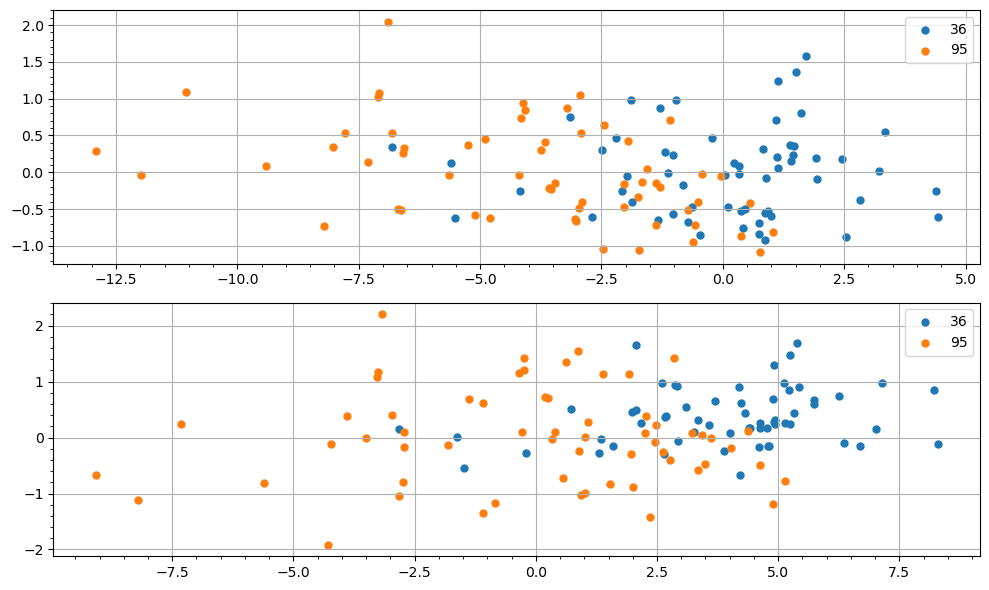

In [21]:
from mlgrad.pca import location, find_pc_all, find_pc_l1_all, find_pc_smoothed_all

ys36 = np.concatenate(
    tuple(d2.select_y_by_attr_value("штамм_бактерий", "36")), axis=0)
ys95 = np.concatenate(
    tuple(d2.select_y_by_attr_value("штамм_бактерий", "95")), axis=0)

print("36:", ys36.shape, "95:", ys95.shape)

c36 = location(ys36)
as36, ls36, us36 = find_pc_all(ys36 - c36, 2, verbose=0)
us36 = (ys36-c36) @ as36.T
us36_95 = (ys95-c36) @ as36.T
# S36 = np.linalg.inv(us36 @ us36.T)

def dist(S, X):
    return np.sqrt([((S@x)@x) for x in X])

# plt.figure(figsize=(10,6))
us36_01 = us36[:,0:2]
S36_01 = np.linalg.inv(us36_01.T @ us36_01)
# plt.scatter(us36_01[:,0], us36_01[:,1], c='r', label="36")
# plots.plot_contour(partial(dist, S36_01), 
#                    (-12,8),
#                    (-5,5),
#                    colors='r',
#                    levels=[0.3]
#                   )
us36_95_01 = us36_95[:,0:2]
# plt.scatter(us36_95_01[:,0], us36_95_01[:,1], c='b', label="95")

c36_95_01 = location(us36_95_01)
as36_95_01, as36_95_01, uu36_95_01 = find_pc_all(us36_95_01 - c36_95_01, 2, verbose=0)


S36_95_01 = np.linalg.inv(uu36_95_01.T @ uu36_95_01)
# plots.plot_contour(partial(dist, S36_95_01), 
#                    (-12,8),
#                    (-5,5),
#                    colors='b',
#                    levels=[0.3]
#                   )
# plt.legend()
# plt.show()

c95 = location(ys95)
as95, ls95, us95 = find_pc_all(ys95 - c95, 3, verbose=0)
us95_s36 = (ys36-c95) @ as95.T
S95 = np.linalg.inv(us95 @ us95.T)

# plt.figure(figsize=(10,6))
# plt.plot(ls36, marker='o', label="36")
# plt.plot(ls95, marker='o', label="95")
# plt.minorticks_on()
# plt.grid(1)
# plt.show()

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.scatter((ys36-c36) @ as36[0], (ys36-c36) @ as36[1], s=25, label="36")
plt.scatter((ys95-c36) @ as36[0], (ys95-c36) @ as36[1], s=25, label="95")
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.subplot(2,1,2)
plt.scatter((ys36-c95) @ as95[0], (ys36-c95) @ as95[1], s=25, label="36")
plt.scatter((ys95-c95) @ as95[0], (ys95-c95) @ as95[1], s=25, label="95")
plt.minorticks_on()
plt.grid(1)
plt.tight_layout()
plt.legend()
plt.show()

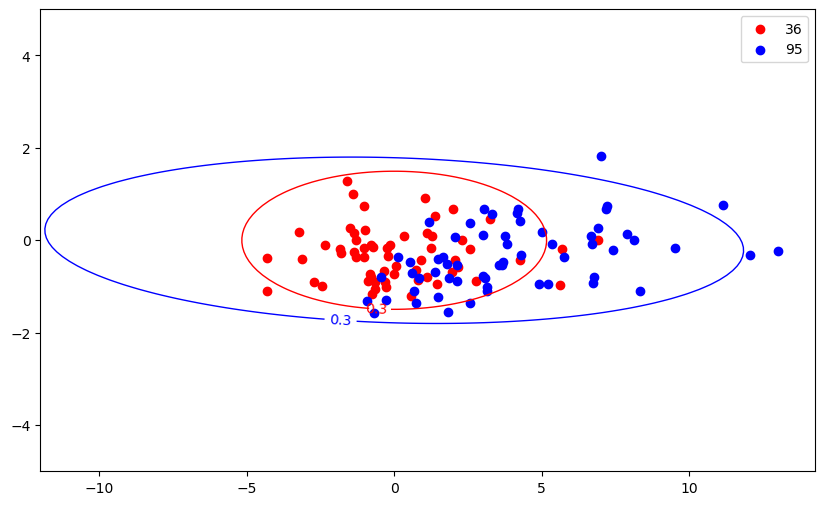

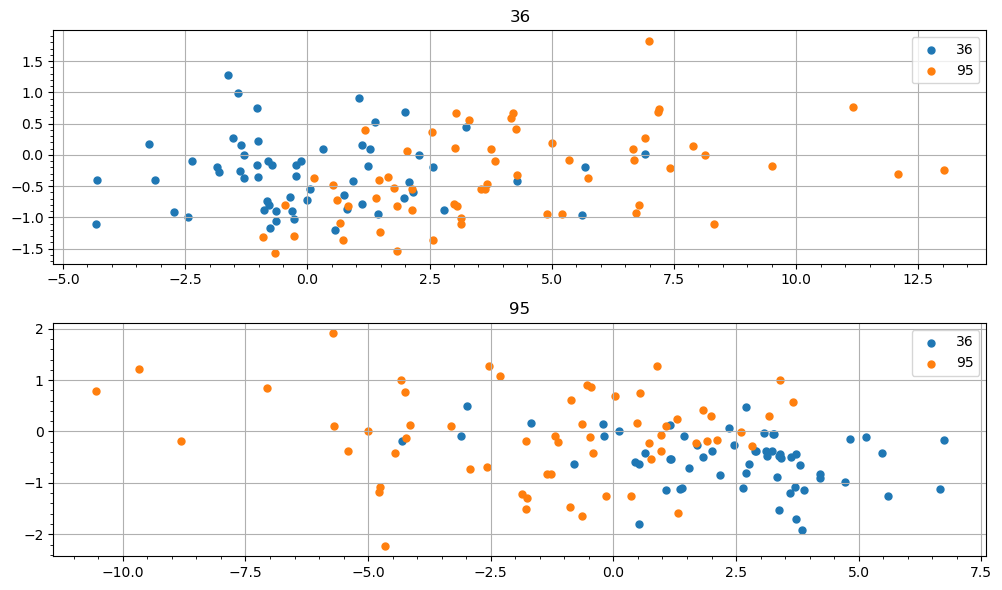

In [14]:
from mlgrad.af import averaging_function
from mlgrad.pca import robust_location, find_robust_pc_all

wma = averaging_function("WMZ", kwds={"alpha":3.5})

c36_r = robust_location(ys36, wma)
as36_r, ls36_r, us36_r = find_robust_pc_all(ys36 - c36_r, wma, 3, verbose=0)
us36_r_95 = (ys95-c36_r) @ as36_r.T

c95_r = robust_location(ys95, wma)
as95_r, ls95_r, us95_r = find_robust_pc_all(ys95 - c95_r, wma, 3, verbose=0)

plt.figure(figsize=(10,6))
us36_r_01 = us36_r[:,0:2]
S36_r_01 = np.linalg.inv(us36_r_01.T @ us36_r_01)
plt.scatter(us36_r_01[:,0], us36_r_01[:,1], c='r', label="36")
plots.plot_contour(partial(dist, S36_r_01), 
                   (-12,12),
                   (-5,5),
                   colors='r',
                   levels=[0.3]
                  )
us36_r_95_01 = us36_r_95[:,0:2]
S36_r_95_01 = np.linalg.inv(us36_r_95_01.T @ us36_r_95_01)
plt.scatter(us36_r_95_01[:,0], us36_r_95_01[:,1], c='b', label="95")
plots.plot_contour(partial(dist, S36_r_95_01), 
                   (-12,12),
                   (-5,5),
                   colors='b',
                   levels=[0.3]
                  )
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.title("36")
plt.scatter((ys36-c36_r) @ as36_r[0], (ys36-c36_r) @ as36_r[1], s=25, label="36")
plt.scatter((ys95-c36_r) @ as36_r[0], (ys95-c36_r) @ as36_r[1], s=25, label="95")
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.subplot(2,1,2)
plt.title("95")
plt.scatter((ys36-c95_r) @ as95_r[0], (ys36-c95_r) @ as95_r[1], s=25, label="36")
plt.scatter((ys95-c95_r) @ as95_r[0], (ys95-c95_r) @ as95_r[1], s=25, label="95")
plt.minorticks_on()
plt.grid(1)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# from mlgrad.pca import location, find_pc_all, find_pc_l1_all, find_pc_smoothed_all

# plt.figure(figsize=(10,5))
# for i, key in enumerate(d2):
#     entry = d2[key]
#     Xs, Ys = entry.x, entry.y

#     C = location(Ys)
#     C = smooth.whittaker_smooth(C, tau2=1.0)
#     # As, Ls, Us = find_pc_all(Ys - C, 2)
#     As2, Ls2, Us2 = find_pc_smoothed_all(Ys - C, 10, tau=1.0)
#     # print(As2)
#     # plt.plot(Ls, marker='o', label=key)
#     plt.figure(figsize=(12,4))
#     # plt.plot(Ls_r, marker='o', label=key)
#     # plt.scatter(Us[0], Us[1], label=key)
#     plt.plot(As2[0], label=key+"-0")
#     plt.plot(As2[1], label=key+"-1")
#     plt.plot(As2[2], label=key+"-2")
#     plt.legend()
#     plt.show()

#     plt.scatter(Us2[0], Us2[1], label=key)
#     plt.tight_layout()
#     plt.legend()
#     plt.show()
#     plt.figure()
#     plt.scatter(Us2[1], Us2[2], label=key)
#     plt.tight_layout()
#     plt.legend()
#     plt.show()


In [ ]:
plt.plot(Ls1, marker='o', label='pca')
plt.plot(Ls2, marker='o', label='pca smoothed')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
for i, A in enumerate(As1[:3]):
    plt.plot(A, label=str(i+1))
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
for i, A in enumerate(As2[:3]):
    plt.plot(A, label=str(i+1))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    # if "_R_" in key:
    #     if "95" in key:
    #         color='r'
    #     elif "96" in key:
    #         color='Brown'
    # elif "_S_" in key:
    #     if "92" in key:
    #         color='m'
    #     elif "93" in key:
    #         color='b'
    #     else:
    #         color='b'

    if "_R_" in key:
        color='r'
    elif "_S_" in key:
        color='b'
    else:
        color='m'
        
    # plt.plot(np.mean(Xs, axis=0), np.mean(Ys, axis=0), linewidth=1.0, color=color, label=key)
    plt.plot(np.mean(Ys, axis=0), linewidth=1.0, label=key)
    
# plt.hlines(0, 0, len(Ys[0]), colors='k')
# plt.xlim(-10,1000)
        
plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import sympy
from sympy import MatrixSymbol, Identity, latex

In [ ]:
from IPython.display import display, Latex

In [ ]:
def latex_matrix(DD):
    n = DD.shape[0]
    s = r"$$\left(\begin{array}{" + n*"l" + "}"
    for i in range(10):
        for j in range(10):
            s += latex(DD[i,j])
            if j < n-1:
                s += r"&"
            else:
                s += r"\\"
    s += r"\end{array}\right)$$"
    # print(s)
    return s

In [ ]:
E = np.eye(10, dtype="i")
D2 = np.diff(E, 2, axis=0)
print(D2)
print(D2.T @ D2)

In [ ]:
w2 = sympy.symarray("w", (10,), )
W2 = np.diag(w2[0:-2])

In [ ]:
DD2 = np.dot(np.dot(D2.T, W2), D2)

In [ ]:
display(Latex(latex_matrix(DD2)))

In [ ]:
D1 = np.diff(np.eye(10, dtype="i"), 1, axis=0, )
print(D1)
print(D1.T @ D1)

In [ ]:
w = sympy.symarray("w", (10,))
W = np.diag(w[:-1])
DD1 = np.dot(np.dot(D1.T, W), D1)

In [ ]:
display(Latex(latex_matrix(DD1)))

In [ ]:
D3 = np.diff(np.eye(10, dtype="i"), 3, axis=0, )
print(D3)
print(D3.T @ D3)

In [ ]:
w3 = sympy.symarray("w", (10,), )
W3 = np.diag(w3[0:-3])

In [ ]:
DD3 = np.dot(np.dot(D3.T, W3), D3)

In [ ]:
display(Latex(latex_matrix(DD3)))

In [ ]:
D4 = np.diff(np.eye(10, dtype="i"), 4, axis=0, )
print(D4)
print(D4.T @ D4)

In [ ]:
w4 = sympy.symarray("w", (10,), )
W4 = np.diag(w4[0:-4])

In [ ]:
DD4 = np.dot(np.dot(D4.T, W4), D4)

In [ ]:
display(Latex(latex_matrix(DD4)))

In [ ]:
import ipywidgets as widgets
import os, time

In [ ]:
buttons = []
for i in range(10):
    buttons.append(widgets.Button(description=f"  The button {i}  "))
box = ipywidgets.Box(buttons)
box.layout = widgets.Layout(flex_flow="row wrap")
box

In [ ]:
fp = widgets.FloatProgress(min=0, max=10, value=0, bar_style="success", description="abcdefghijklmnopqrstuv")
fp.style.width=32
display(fp)
for i in range(11):
    time.sleep(1)
    fp.value=i